## Predict a global signal with the pretrained emulator

In [1]:
import sys
sys.path.append('..')
import VeryAccurateEmulator

2021-11-10 00:00:54.515212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/s/sievers/cbye/lib:/home/s/sievers/cbye/lib:/opt/slurm/lib64:/scinet/niagara/software/2019b/core/lib64
2021-11-10 00:00:54.515238: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
pretrained_model = VeryAccurateEmulator.VeryAccurateEmulator()  # the pretrained emulator

2021-11-10 00:00:56.342119: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/s/sievers/cbye/lib:/home/s/sievers/cbye/lib:/opt/slurm/lib64:/scinet/niagara/software/2019b/core/lib64
2021-11-10 00:00:56.342155: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-10 00:00:56.342183: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nia-jupyter.scinet.local): /proc/driver/nvidia/version does not exist
2021-11-10 00:00:56.342451: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow 

In [3]:
# you can also load your own pretrained models saved to h5 Files like this:

# from tensorflow.keras.models import load_model
# my_emulator = load_model(<filepath>)
# my_vae = load_model(<filepath>)
# my_model = VeryAccurateEmulator.VeryAccurateEmulator(vae=my_vae, emulator=my_emulator)

In [4]:
# access the input parameters and their order
print(pretrained_model.par_labels)

['fstar', 'Vc', 'fx', 'tau', 'alpha', 'nu_min', 'Rmfp']


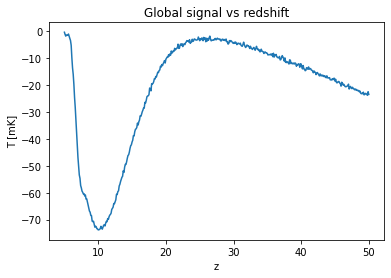

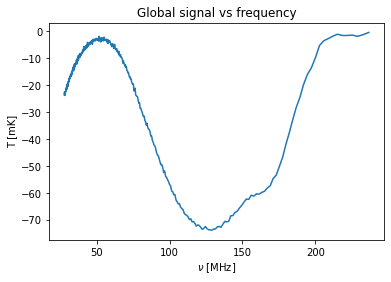

In [5]:
params = [0.0003, 4.2, 0, 0.055, 1.0, 0.1, 10]  # in the order given in the above cell

# alternatively, params can be a (N, 7)-numpy array, where N is the number of different cases you want to emulate at once.
# In that case, the output is a (N, 451)-numpy array. 
# For example, if you have a csv file with 500 cases organized in a 500x7-table, just do 
# params = np.loadtxt(<filepath>)

global_signal = pretrained_model.predict(params)  # emulate the global signal

import matplotlib.pyplot as plt
redshifts = pretrained_model.z_sampling  # an array of length 451 with redshifts 5-50:0.1
plt.figure()
plt.plot(redshifts, global_signal)
plt.title('Global signal vs redshift')
plt.xlabel('z')
plt.ylabel('T [mK]')
plt.show()

frequencies = pretrained_model.nu_sampling  # an array of length 451 with equivalent frequencies
plt.figure()
plt.plot(frequencies, global_signal)
plt.title('Global signal vs frequency')
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel('T [mK]')
plt.show()

In [6]:
import numpy as np
err = pretrained_model.compute_rms_error() # compute the relative error, with no input arguments, this computes the error on
# the same test set as used in the paper

# compute the absolute error in the frequency range 50-100 MHz, must set relative to False
abs_err = pretrained_model.compute_rms_error(relative=False, flow=50, fhigh=100)
print('Mean relative rms error:', np.mean(err))
print('Mean rms error in mK for frequencies between 50-100 MHz:', np.mean(abs_err))

# since we used no input arguments, we are testing the pretrained model on the test set in the paper. Thus, the results
# should match those given in Table 1 of the paper.

Mean relative rms error: 0.0034342164
Mean rms error in mK for frequencies between 50-100 MHz: 0.49636072


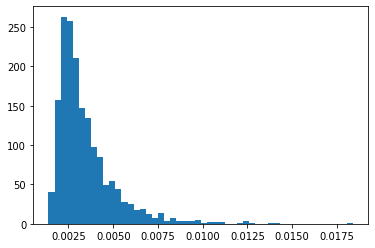

In [7]:
# Histogram of errors, should look like Figure 2 of the paper
plt.hist(err, bins=50)
plt.show()

## Training a new model

In [8]:
custom_model = VeryAccurateEmulator.VeryAccurateEmulator() # instantiate the 21cmVAE class

In [9]:
custom_model.get_hyperparameters() # the default hyperparameters

Hyperparameters are set to:
Direct emulator hidden dimensions: [288, 352, 288, 224]
Activation function: relu


In [11]:
# change the hyperparameters: the available hyperparameters are called "direct_em_dims", and "activation_func". 
# This is also mentioned in the docstring. 

latent_dimension = 12
direct_em_dims = [64, 128]
custom_model.set_hyperparameters(hidden_dims=direct_em_dims, activation_func='relu')
custom_model.get_hyperparameters() # the new hyperparameters

Hyperparameters are set to:
Direct emulator hidden dimensions: [64, 128]
Activation function: relu


In [12]:
# example of how to access the docstring in jupyter notebook, this can be used for any function:
custom_model.set_hyperparameters?

In [13]:
custom_model.train(epochs=50) # This takes 16 input keyword arguments, check the docstring for all their names; they include
# the training dataset, learning rate, number of epochs, and arguments that control early stopping and learning rate schedule.
# As usual, the function can be passed without arguments, in which case they default to the previously used arguments
# (or the arguments we used in the pretrained emulator, if this is the first run)

Model Compiled: Emulator
Epoch 1/50
96/96 [==============================] - 1s 6ms/step - loss: 7.1386e-05 - val_loss: 3.1690e-05 - lr: 0.0100
Epoch 2/50
96/96 [==============================] - 0s 4ms/step - loss: 1.8188e-05 - val_loss: 1.2142e-05 - lr: 0.0100
Epoch 3/50
96/96 [==============================] - 0s 4ms/step - loss: 8.9396e-06 - val_loss: 6.4656e-06 - lr: 0.0100
Epoch 4/50
96/96 [==============================] - 0s 5ms/step - loss: 5.1655e-06 - val_loss: 4.2409e-06 - lr: 0.0100
Epoch 5/50
96/96 [==============================] - 0s 4ms/step - loss: 3.7150e-06 - val_loss: 3.2462e-06 - lr: 0.0100
Epoch 6/50
96/96 [==============================] - 0s 5ms/step - loss: 2.9098e-06 - val_loss: 2.5750e-06 - lr: 0.0100
Epoch 7/50
96/96 [==============================] - 0s 4ms/step - loss: 2.3686e-06 - val_loss: 2.1585e-06 - lr: 0.0100
Epoch 8/50
96/96 [==============================] - 0s 4ms/step - loss: 1.9961e-06 - val_loss: 1.8561e-06 - lr: 0.0100
Epoch 9/50
96/96 [=====

In [14]:
custom_err = custom_model.compute_rms_error() # compute the relative error, with no input arguments, this computes the error on
# the same test set as used in the paper

# How does this model compare to the pretrained model?
print('Mean relative rms error of pretrained model:', np.mean(err))
print('Mean relative rms error of custom model:', np.mean(custom_err))

# As expected, since we picked random hyperparameters and only trained for 50 epochs ...

Mean relative rms error of pretrained model: 0.0034342164
Mean relative rms error of custom model: 0.0142781455


## The Autoencoder-Based Emulator

The Autoencoder-based Emulator (see Appendix A) has it's own class. It works similarly to the other emulator and has mostly the same methods.

In [15]:
ae_em = VeryAccurateEmulator.AutoEncoderEmulator()

In [16]:
ae_em_error = ae_em.compute_rms_error()
print('Relative rms error for direct emulator is:', np.mean(ae_em_error))

Relative rms error for direct emulator is: 0.0038806251


In [17]:
custom_ae_em = VeryAccurateEmulator.AutoEncoderEmulator()
custom_ae_em.get_hyperparameters() # the default hyperparameters

Hyperparameters are set to:
Latent dimension: 9
Encoder dimensions: [352]
Decoder dimensions: [32, 352]
Emulator dimensions: [352, 352, 352, 224]
Activation function: relu


In [18]:
# change architecture
latent_dim = 22
encoder_dims = [32, 64]
decoder_dims = [64, 32]
em_dims = [32, 128, 256]

custom_ae_em.set_hyperparameters(latent_dim=latent_dim, encoder_dims=encoder_dims, decoder_dims=decoder_dims,
                                em_dims=em_dims)
custom_ae_em.get_hyperparameters() # the new hyperparameters

Hyperparameters are set to:
Latent dimension: 22
Encoder dimensions: [32, 64]
Decoder dimensions: [64, 32]
Emulator dimensions: [32, 128, 256]
Activation function: relu


In [19]:
custom_ae_em.train(epochs=10)

Train Autoencoder
Model Compiled: AutoEncoder
Epoch 1/10
96/96 [==============================] - 1s 6ms/step - loss: 3.3647e-05 - val_loss: 6.1026e-06 - lr: 0.0100
Epoch 2/10
96/96 [==============================] - 0s 4ms/step - loss: 3.4491e-06 - val_loss: 1.8368e-06 - lr: 0.0100
Epoch 3/10
96/96 [==============================] - 0s 4ms/step - loss: 1.3980e-06 - val_loss: 1.0209e-06 - lr: 0.0100
Epoch 4/10
96/96 [==============================] - 0s 4ms/step - loss: 9.1020e-07 - val_loss: 8.2506e-07 - lr: 0.0100
Epoch 5/10
96/96 [==============================] - 0s 4ms/step - loss: 6.7046e-07 - val_loss: 5.3437e-07 - lr: 0.0100
Epoch 6/10
96/96 [==============================] - 0s 4ms/step - loss: 6.0153e-07 - val_loss: 4.2342e-07 - lr: 0.0100
Epoch 7/10
96/96 [==============================] - 0s 4ms/step - loss: 3.6788e-07 - val_loss: 3.4539e-07 - lr: 0.0100
Epoch 8/10
96/96 [==============================] - 0s 4ms/step - loss: 3.2604e-07 - val_loss: 3.9529e-07 - lr: 0.0100
Ep

In [20]:
custom_autoencoder_em_err = custom_ae_em.compute_rms_error()

# How does this model compare to the pretrained model?
print('Mean relative rms error of pretrained direct emulator:', np.mean(ae_em_error))
print('Mean relative rms error of custom direct emulator:', np.mean(custom_autoencoder_em_err))

# As expected ...

Mean relative rms error of pretrained direct emulator: 0.0038806251
Mean relative rms error of custom direct emulator: 0.019583795
